In [1]:
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random
import os
import copy
import datetime
import time

In [2]:
import torch
from torch import nn
from torchvision import transforms

In [3]:
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

In [4]:
from nes_py.wrappers import JoypadSpace

In [5]:
import gym_super_mario_bros

## RL Definitions
Environment The world that an agent interacts with and learns from.

### Action ```a``` : 
How the Agent responds to the Environment. The set of all possible Actions is called action-space.

### State ```s``` : 
The current characteristic of the Environment. The set of all possible States the Environment can be in is called state-space.

### Reward ```r``` : 
Reward is the key feedback from Environment to Agent. It is what drives the Agent to learn and to change its future action. An aggregation of rewards over multiple time steps is called Return.

### Optimal Action-Value function 
```latex
Q*(s,a)
``` 
Gives the expected return if you start in state ss, take an arbitrary action aa, and then for each future time step take the action that maximizes returns. Q can be said to stand for the “quality” of the action in a state. We try to approximate this function.

### Environment
Initialize Environment
In Mario, the environment consists of tubes, mushrooms and other components.

When Mario makes an action, the environment responds with the changed (next) state, reward and other info.

In [6]:
env = gym_super_mario_bros.make("SuperMarioBros-v0")

actions = [['right'],['right','A']]
env = JoypadSpace(env, actions)

In [7]:
env.reset()

next_state, reward, done, info = env.step(action=0)

print(f"Next-State shape: {next_state.shape}, \n Reward: {reward}, \n Completed Stage: {done}, \n Information: {info}")

Next-State shape: (240, 256, 3), 
 Reward: 0, 
 Completed Stage: False, 
 Information: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'y_pos': 79}


## Preprocess Environment
Environment data is returned to the agent in next_state. As you saw above, each state is represented by a [3, 240, 256] size array. Often that is more information than our agent needs; for instance, Mario’s actions do not depend on the color of the pipes or the sky!

We use Wrappers to preprocess environment data before sending it to the agent.

```GrayScaleObservation``` is a common wrapper to transform an RGB image to grayscale; doing so reduces the size of the state representation without losing useful information. Now the size of each state: [1, 240, 256]

```ResizeObservation``` downsamples each observation into a square image. New size: [1, 84, 84]

```SkipFrame``` is a custom wrapper that inherits from ```gym.Wrapper``` and implements the ```step()``` function. Because consecutive frames don’t vary much, we can skip n-intermediate frames without losing much information. The n-th frame aggregates rewards accumulated over each skipped frame.

```FrameStack``` is a wrapper that allows us to squash consecutive frames of the environment into a single observation point to feed to our learning model. This way, we can identify if Mario was landing or jumping based on the direction of his movement in the previous several frames.

In [8]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, n_skip):
        """
            Return's only every n_skip'th frame
        """
        super().__init__(env)
        self._skip = n_skip
    
    def step(self, action):
        """
            Repeare action and sum reward
        """

        total_reward = 0.0
        done = False
        for i in range(self._skip):
            # accumulate reward and repeate the same action
            obs, reward, done, info = self.env.step(action)
            total_reward+=reward
            if done:
                break
        return obs, total_reward, done, info

In [9]:
class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)

        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)
    
    def permute_orientation(self, observation):
        # permute the [H,W,C] array to [C,H,W] tensor

        observation = np.transpose(observation, (2,0,1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation
    
    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = transforms.Grayscale()
        observation = transform(observation)
        return observation


In [10]:
class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)

        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)
        
        obs_shape = self.shape + self.observation_space.shape[2:]

        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)
    
    def observation(self, observation):
        transform = transforms.Compose(
            [transforms.Resize(self.shape),
            transforms.Normalize(0,255)]
        )
        observation = transform(observation).squeeze(0)

        return observation

In [11]:
env = SkipFrame(env, n_skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=4)

## Agent
We create a class Mario to represent our agent in the game. Mario should be able to:
<ul>
<li> <b>Act</b> according to the optimal action policy based on the current state (of the environment).
<li> <b>Remember</b> experiences. Experience = (current state, current action, reward, next state). Mario caches and later recalls his experiences to update his action policy.
<li> <b>Learn</b> a better action policy over time
<ul>

### Act
For any given state, an agent can choose to do the most optimal action (exploit) or a random action (explore).

Mario randomly explores with a chance of self.exploration_rate; when he chooses to exploit, he relies on MarioNet (implemented in Learn section) to provide the most optimal action.

### Cache and Recall
These two functions serve as Mario’s “memory” process.

```cache()```: Each time Mario performs an action, he stores the experience to his memory. His experience includes the current state, action performed, reward from the action, the next state, and whether the game is done.

```recall()```: Mario randomly samples a batch of experiences from his memory, and uses that to learn the game.

### Learn
Mario uses the DDQN algorithm under the hood. DDQN uses two ConvNets - $ Q_{online} $ and $ Q_{target} $- that independently approximate the optimal action-value function.

In our implementation, we share feature generator features across $ Q_{online} $ and $ Q_{target} $, but maintain separate FC classifiers for each. $ \theta_{target} $(the parameters of $ Q_{target} $) is frozen to prevent updation by backprop. Instead, it is periodically synced with $ \theta_{online} $(more on this later).

TD Estimate & TD Target
Two values are involved in learning:

TD Estimate - the predicted optimal $ Q^* $ for a given state ```s``` 
$ {TD}_e = Q_{online}^*(s,a) $

TD Target - aggregation of current reward and the estimated $ Q^* $ in the next state ```s'``` 

$ a' = argmax_{a} Q_{online}(s', a) $

$ {TD}_t = r + \gamma Q_{target}^*(s',a') $

Because we don’t know what next action ```a'``` will be, we use the action ```a'``` maximizes $ Q_{online} $ in the next state ```s'.```
Notice we use the ```@torch.no_grad()``` decorator on ```td_target()``` to disable gradient calculations here (because we don’t need to backpropagate on $ \theta_{target} $)

### Updating the model
As Mario samples inputs from his replay buffer, we compute $TD_t$ and $TD_e$ and backpropagate this loss down $Q_{online}$ to update its parameters $ \theta_{online} $ ($ \alpha $ is the learning rate ```lr``` passed to the optimizer)

$ \theta_{online} \leftarrow \theta_{online} + \alpha \nabla(TD_e - TD_t) $

$ \theta_{target} $ does not update through backpropagation. Instead, we periodically copy $ \theta_{online} $ to $ \theta_{target} $

$ \theta_{target} \leftarrow \theta_{online} $


In [12]:
class Mario:
    def __init__(self, state_dim, action_dim, save_dir):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_dir = save_dir

        self.use_cuda = torch.cuda.is_available()

        # Mario's DNN to predict the most optimal action 

        self.online_net = MarioOnlineNet(self.state_dim, self.action_dim).float()
        self.target_net = MarioTargetNet(self.state_dim, self.action_dim).float()

        if self.use_cuda:
            self.online_net = self.online_net.to(device='cuda')
            self.target_net = self.target_net.to(device='cuda')
        
        self.exploration_rate = 1
        self.exploration_rate_decay = 0.999975
        self.exploration_rate_min = 0.1
        self.curr_step = 0

        # number of experiences between saving Mario Net 
        self.save_every = 5e5

        # replay buffer
        self.memory = deque(maxlen=100000)
        self.batch_size = 32

        # Q-Learning params
        self.gamma = 0.9

        # backpropagation params
        self.optimizer = torch.optim.Adam(self.online_net.parameters(), lr=0.0025)
        self.loss_fn = torch.nn.SmoothL1Loss()

        # learning params
        self.burnin = 1e4 # minimum experiences before training
        self.learn_every = 3 # number of experiences between updates to Q_online
        self.sync_every = 1e4 # number experiences betweem Q_online and Q_target sync

    def act(self, state):
        """
            Given a state, choose an epsilon-greedy action and update value of step.

            Inputs:
                state(LazyFrame): A single observation of the current state, dimension is (state_dim)
            Outputs:
                action_idx(int): An integer representing which action Mario will perform
        """
        # EXPLORE
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)
        
        # EXPLOIT
        else:
            state = state.__array__()
            if self.use_cuda:
                state = torch.tensor(state).cuda()
            else:
                state = torch.tensor(state)
            
            state = state.unsqueeze(0)
            action_values = self.online_net(state)
            action_idx = torch.argmax(action_values, axis=1).item()
        
        # decrease exploration rate
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate, self.exploration_rate_min)

        # increment step
        self.curr_step+=1

        return action_idx

    def cache(self, state, next_state, action, reward, done):
        """
            Stores the experience to self.memory (replay buffer)

            Inputs:
                state(LazyFrame)
                next_step(LazyFrame)
                action(int)
                reward(float)
                done(bool)
        """
        state = state.__array__()
        next_state = next_state.__array__()

        if self.use_cuda:
            state = torch.tensor(state).cuda()
            next_state = torch.tensor(next_state).cuda()
            action = torch.tensor([action]).cuda()
            reward = torch.tensor([reward]).cuda()
            done = torch.tensor([done]).cuda()
        else:
            state = torch.tensor(state)
            next_state = torch.tensor(next_state)
            action = torch.tensor([action])
            reward = torch.tensor([reward])
            done = torch.tensor([done])
        
        self.memory.append((
            state,
            next_state,
            action,
            reward,
            done
        ))

    def recall(self):
        """
            Retrive a batch of experiences from memory
        """
        batch = random.sample(self.memory, self.batch_size)
        state, next_state, action, reward, done = map(torch.stack, zip(*batch))

        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()

    def learn(self):
        """
            Update online action value (Q) function with a batch of experiences
        """
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()
        
        if self.curr_step % self.save_every == 0:
            self.save()
        
        if self.curr_step < self.burnin:
            return None, None
        
        if self.curr_step % self.learn_every != 0:
            return None, None
        
        # sample from the replay memory
        state, next_state, action, reward, done = self.recall()

        # get TD estimate
        td_est = self.td_estimate(state, action)

        # get TD target
        td_tgt = self.td_target(reward, next_state, done)

        # backpropagate loss through Q_online
        loss = self.update_Q_online(td_est, td_tgt)

        return (td_est.mean().item(), loss)
        

    def td_estimate(self, state, action):
        # Q_online(s,a)
        current_Q = self.online_net(state)[np.arange(0, self.batch_size), action]

        return current_Q
    
    @torch.no_grad()
    def td_target(self, reward, next_state, done):

        next_state_Q = self.target_net(next_state)
        # a'
        best_action = torch.argmax(next_state_Q, axis=1)

        # Q_target(s',a')
        next_Q = self.target_net(next_state)[np.arange(0, self.batch_size), best_action]

        return ( reward + (1 - done.float()) * self.gamma * next_Q ).float()
    
    def update_Q_online(self, td_estimate, td_target):
        loss = self.loss_fn(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()
    
    def sync_Q_target(self):
        self.target_net.load_state_dict(self.online_net.state_dict())
    
    def save(self):
        save_path = (
            self.save_dir/f"mario_net_{int(self.curr_step)//self.save_every}.chkpt"
        )

        torch.save(
            dict(online_model=self.online_net.state_dict(),
                target_model=self.target_net.state_dict(),
                exploration_rate=self.exploration_rate),
            save_path,
        )

        print(f"MarioNet saved to {save_path} at step {self.curr_step}")

In [13]:
class MarioOnlineNet(nn.Module):
    """
        CNN structure:
            input -> (conv2d+relu)*3 -> flatten -> (dense + relu)*2 -> output
    """
    def __init__(self, input_dim, output_dim):
        super().__init__()

        c, h, w = input_dim

        if h!=84:
            raise ValueError(f"Expecting input height: 84 got: {h}")
        
        if w!=84:
            raise ValueError(f"Expecting input width: 84 got: {w}")
        
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=3136, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512,out_features=output_dim),
        )

               
    def forward(self, input):
        return self.net(input)

class MarioTargetNet(nn.Module):
    """
        CNN structure:
            input -> (conv2d+relu)*3 -> flatten -> (dense + relu)*2 -> output
    """
    def __init__(self, input_dim, output_dim):
        super().__init__()

        c, h, w = input_dim

        if h!=84:
            raise ValueError(f"Expecting input height: 84 got: {h}")
        
        if w!=84:
            raise ValueError(f"Expecting input width: 84 got: {w}")
        
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=3136, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512,out_features=output_dim),
        )

        

        # Q-target parameters are frozen
        for p in self.net.parameters():
            p.requires_grad = False
        
    def forward(self, input, model="online"):            
        return self.net(input)

### Logging

In [14]:
import matplotlib.pyplot as plt 

class MetricLogger:
    def __init__(self, save_dir):
        self.save_log = save_dir/"log"

        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )
        
        # saving the plots
        self.ep_rewards_plot = save_dir/"reward_plot.png"
        self.ep_lengths_plot = save_dir/"length_plot.png"
        self.ep_avg_losses_plot = save_dir/"loss_plot.png"
        self.ep_avg_qs_plot = save_dir/"q_plot.png"

        # history metircs
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        # moving averages added for every call to record
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []

        # current episode metric
        self.init_episode()

        # timing
        self.record_time = time.time()

    def log_step(self, reward, loss, q):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1 

    def log_episode(self):
        """
            marking the end of the episode
        """
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss/self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q/self.curr_ep_loss_length, 5)
        
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()
    
    def init_episode(self):
        self.curr_ep_reward = 0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0
    
    def record(self, episode, epsilon, step):
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)

        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time)

        print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {epsilon} - "
            f"Mean Reward {mean_ep_reward} - "
            f"Mean Length {mean_ep_length} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
            f"Time Delta {time_since_last_record} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )

        with open(self.save_log, "a") as f:
            f.write(
                f"{episode:8d}{step:8d}{epsilon:10.3f}"
                f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}{mean_ep_loss:15.3f}{mean_ep_q:15.3f}"
                f"{time_since_last_record:15.3f}"
                f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n"
            )
        
        for metric in ["ep_rewards", "ep_lengths", "ep_avg_losses", "ep_avg_qs"]:
            plt.plot(getattr(self, f"moving_avg_{metric}"))
            plt.savefig(getattr(self, f"{metric}_plot"))
            plt.show()


Using CUDA: True



c:\Users\preet\.conda\envs\mldl\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))
C:\Users\preet\AppData\Local\Temp/ipykernel_4984/1849942595.py:95: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done]).cuda()


Episode 0 - Step 1042 - Epsilon 0.9742860568148791 - Mean Reward 2278.0 - Mean Length 1042.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 17.0 - Time 2022-05-24T00:39:35


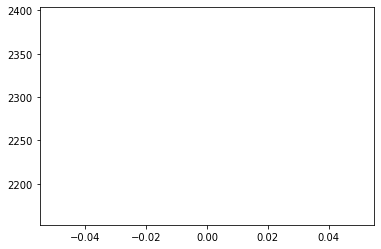

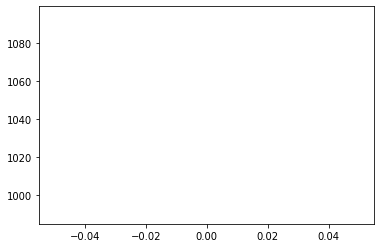

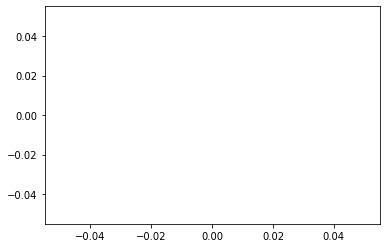

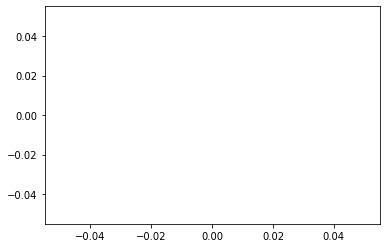

In [15]:
use_cuda = torch.cuda.is_available()
print(f"Using CUDA: {use_cuda}")
print()

save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

mario = Mario(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=save_dir)

logger = MetricLogger(save_dir)

episodes = 10000
for e in range(episodes):

    state = env.reset()

    # Play the game!
    while True:
        env.render()

        # Run agent on the state
        action = mario.act(state)

        # Agent performs action
        next_state, reward, done, info = env.step(action)

        # Remember
        mario.cache(state, next_state, action, reward, done)

        # Learn
        q, loss = mario.learn()

        # Logging
        logger.log_step(reward, loss, q)

        # Update state
        state = next_state

        # Check if end of game
        if done or info["flag_get"]:
            break

    logger.log_episode()

    if e % 20 == 0:
        logger.record(episode=e, epsilon=mario.exploration_rate, step=mario.curr_step)